# Threshold candidate detection (long paths in actual building interior)

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
import glob

# Parameters
DATA_FOLDER = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\data\raw\b2"
OUTPUT_FOLDER = r"C:\Users\shrua\OneDrive\Desktop\threshold project\threshold\data\processed"
PEAK_Z = 0.6

# change this for every type!!
type_id = "b2"

In [42]:
def detect_threshold_candidates(z_scores, peak_z=1.2, min_idx=3, max_idx=None):
    if max_idx is None:
        max_idx = len(z_scores) - 4

    peaks = []

    for i in range(2, len(z_scores) - 2):
        if z_scores[i] < peak_z:
            continue

        if (z_scores[i - 2] < z_scores[i - 1] < z_scores[i] > z_scores[i + 1] > z_scores[i + 2]):
            if min_idx <= i <= max_idx:
                peaks.append(i)

    return peaks


## visualize for the first path

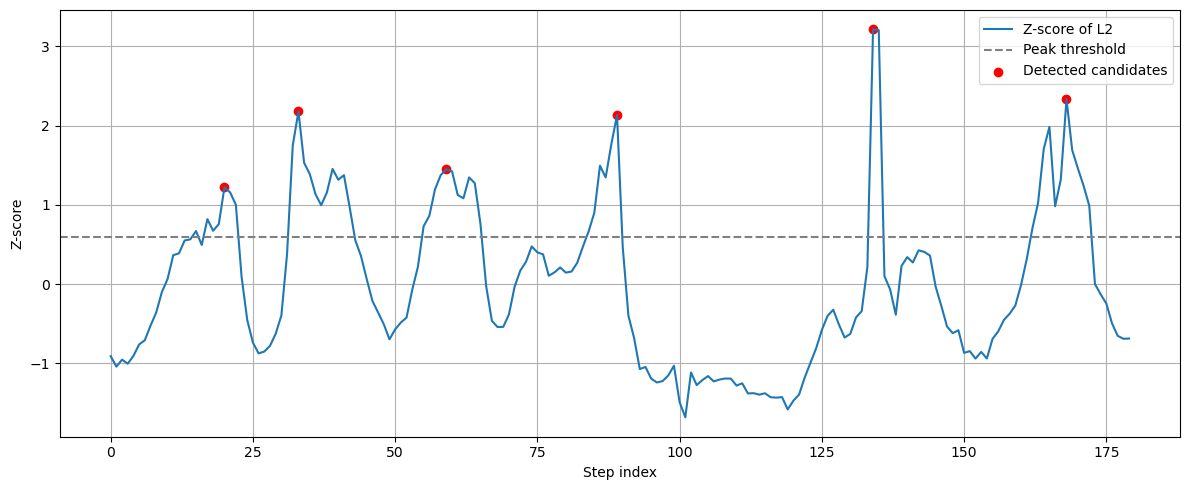

In [43]:
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "curve_*.csv")))
first_file = csv_files[2]
data = np.loadtxt(first_file, delimiter=",").T  # shape: (N, 2048)
n_points = data.shape[0]

diffs = np.linalg.norm(data[1:] - data[:-1], axis=1)
z_scores = (diffs - np.mean(diffs)) / np.std(diffs)
candidates = detect_threshold_candidates(z_scores, PEAK_Z, min_idx=3, max_idx=n_points - 4)

plt.figure(figsize=(12, 5))
plt.plot(z_scores, label="Z-score of L2")
plt.axhline(PEAK_Z, color="gray", linestyle="--", label="Peak threshold")
plt.scatter(candidates, z_scores[candidates], color="red", label="Detected candidates")
plt.xlabel("Step index")
plt.ylabel("Z-score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## detect threshold peaks

In [45]:
results = []
for file in csv_files:
    filename = os.path.basename(file)
    data = np.loadtxt(file, delimiter=",").T
    n = data.shape[0]
    diffs = np.linalg.norm(data[1:] - data[:-1], axis=1)
    z = (diffs - np.mean(diffs)) / np.std(diffs)
    candidates = detect_threshold_candidates(z, PEAK_Z, 3, n - 4)

    for c in candidates:
        results.append({
            "csv_file": filename,
            "candidate_idx": c
        })

df = pd.DataFrame(results)
df_path = os.path.join(OUTPUT_FOLDER, f"{type_id}_all_candidates_metadata.csv")
df.to_csv(df_path, index=False)
print(f"{len(df)} candidates from {len(csv_files)} paths")

16 candidates from 3 paths


## 7-frame windows

In [ ]:
all_windows = []
for file in csv_files:
    filename = os.path.basename(file)
    path_id = os.path.splitext(filename)[0]
    data = np.loadtxt(file, delimiter=",").T
    n = data.shape[0]
    diffs = np.linalg.norm(data[1:] - data[:-1], axis=1)
    z = (diffs - np.mean(diffs)) / np.std(diffs)
    candidates = detect_threshold_candidates(z, PEAK_Z, NEIGHBOR_Z, WINDOW, 3, n - 4)

    for c in candidates:
        start = max(0, c - 3)
        end = min(n, c + 4)
        window = data[start:end]  # shape: (<=7, 2048)

        out_name = f"{type_id}_{path_id}_peak_{c:03d}.npy"
        out_path = os.path.join(OUTPUT_FOLDER, out_name)
        np.save(out_path, window)
        all_windows.append({
            "csv_file": filename,
            "candidate_idx": c,
            "start_idx": start,
            "end_idx": end,
            "window_file": out_name
        })

pd.DataFrame(all_windows).to_csv(df_path, index=False)
print(f"exported {len(all_windows)} .npy files")